# NYPD Datenexploration und Bereinigung

In diesem Notebook werden die polizeilich erfassten Verkehrsunfälle (Motor Vehicle Collisions) des Jahres 2023 analysiert und für die weitere Nutzung aufbereitet.

Der Ablauf gliedert sich in zwei Schritte:

**1. Explorative Untersuchung der Rohdaten**

Zu Beginn werden Aufbau, Datenqualität und charakteristische Merkmale des Crash-Datensatzes untersucht.
Dazu zählen u. a. die Konsistenz der Zeitangaben, die Klassifikation der Fahrzeugtypen, die Identifikation von Fahrrad-/E-Bike-Unfällen sowie die Qualität der gemeldeten Koordinaten.
Die Exploration schafft ein Verständnis dafür, welche Bereinigungsschritte notwendig und sinnvoll sind.

**2. Erstellung eines konsistent bereinigten Datensatzes**

Auf Basis dieser Erkenntnisse wird anschließend ein final bereinigter Datensatz erzeugt, bei dem alle Schritte in definierter Reihenfolge reproduzierbar ausgeführt werden.
Dieser Datensatz bildet die Grundlage für alle späteren Analysen.

Die Trennung von Exploration und finaler Bereinigung stellt sicher, dass sowohl die Untersuchung der Rohdaten nachvollziehbar bleibt als auch die Bereinigung konsistent und transparent durchgeführt wird.

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os

from citibike_analysis.utils.load_data import load_nypd_raw
from citibike_analysis.utils.paths import DATA_PROCESSED
from citibike_analysis.utils.paths import FIGURES_DIR

## 1. Laden und erster Überblick über die Daten

In [37]:
# NYPD-Rohdaten laden (nutzt bestehendes Parquet oder erstellt es aus der CSV)
df_nypd_raw = load_nypd_raw()

# Überblick über die resultierende Tabellenform
print("Form des Datensatzes (Zeilen, Spalten):", df_nypd_raw.shape)

NYPD-Daten aus bestehender Datei geladen: nypd_raw.parquet
Form des Datensatzes (Zeilen, Spalten): (96606, 29)


In [38]:
# Erste 5 Zeilen anzeigen
df_nypd_raw.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,01/01/2023,5:30,None,NaN,40.710514,-73.956140,"(40.710514, -73.95614)",BROOKLYN QUEENS EXPRESSWAY,None,None,...,Unspecified,None,None,None,4599014,Sedan,None,None,None,None
1,01/01/2023,8:45,BRONX,10457.0,40.845870,-73.890730,"(40.84587, -73.89073)",None,None,1972 CROTONA AVENUE,...,Unspecified,Unspecified,None,None,4598137,Sedan,Sedan,Station Wagon/Sport Utility Vehicle,None,None
2,01/01/2023,19:00,BROOKLYN,11206.0,40.708237,-73.943370,"(40.708237, -73.94337)",None,None,179 GRAHAM AVENUE,...,None,None,None,None,4599015,Station Wagon/Sport Utility Vehicle,None,None,None,None
3,01/01/2023,16:35,BROOKLYN,11221.0,40.693660,-73.931540,"(40.69366, -73.93154)",None,None,1073 DE KALB AVENUE,...,Unspecified,Unspecified,Unspecified,None,4599499,Station Wagon/Sport Utility Vehicle,Station Wagon/Sport Utility Vehicle,Sedan,Sedan,None
4,01/01/2023,0:00,QUEENS,11101.0,40.745068,-73.936356,"(40.745068, -73.936356)",30 PLACE,THOMSON AVENUE,None,...,Unspecified,None,None,None,4599239,Station Wagon/Sport Utility Vehicle,Sedan,None,None,None


In [39]:
# Übersicht über Spalten und Datentypen
df_nypd_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96606 entries, 0 to 96605
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   CRASH DATE                     96606 non-null  object 
 1   CRASH TIME                     96606 non-null  object 
 2   BOROUGH                        65728 non-null  object 
 3   ZIP CODE                       65716 non-null  float64
 4   LATITUDE                       89321 non-null  float64
 5   LONGITUDE                      89321 non-null  float64
 6   LOCATION                       89321 non-null  object 
 7   ON STREET NAME                 69853 non-null  object 
 8   CROSS STREET NAME              46818 non-null  object 
 9   OFF STREET NAME                26752 non-null  object 
 10  NUMBER OF PERSONS INJURED      96606 non-null  int64  
 11  NUMBER OF PERSONS KILLED       96606 non-null  int64  
 12  NUMBER OF PEDESTRIANS INJURED  96606 non-null 

---

## 2. Exploration der Daten

### 2.1 Zeitliche Eigenschaften der Unfalldaten

In [40]:
df_nypd = df_nypd_raw.copy()

# Rekonstruktion des vollständigen Zeitstempels (Datum und Uhrzeit)
df_nypd['crash_datetime'] = pd.to_datetime(
    df_nypd['CRASH DATE'].astype(str).str.strip() + " " +
    df_nypd['CRASH TIME'].astype(str).str.strip(),
    errors='coerce'
)

print("Frühester Unfallzeitpunkt:", df_nypd['crash_datetime'].min())
print("Spätester Unfallzeitpunkt:", df_nypd['crash_datetime'].max())

Frühester Unfallzeitpunkt: 2023-01-01 00:00:00
Spätester Unfallzeitpunkt: 2023-12-31 23:18:00


### 2.2 Duplikate

In [41]:
# Anzahl duplizierter Zeilen prüfen
duplicate_rows = df_nypd.duplicated().sum()
print(f"Anzahl duplizierter Zeilen: {duplicate_rows:,}")

# Ansicht, falls Duplikate existieren
if duplicate_rows > 0:
    df_nypd[df_nypd.duplicated(keep=False)].head()

Anzahl duplizierter Zeilen: 0


### 2.3 Fahrzeugtypen

In [42]:
# Fahrzeugtypen aus allen fünf Vehicle-Code-Spalten extrahieren
vehicle_cols = [
    'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
    'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
    'VEHICLE TYPE CODE 5'
]

unique_vehicle_types = set()

# Alle Spalten durchgehen und Werte sammeln
for col in vehicle_cols:
    vals = (
        df_nypd[col]
        .dropna()               # fehlende Werte ignorieren
        .astype(str)            # einheitlich als String
        .str.strip()            # Whitespace entfernen
        .str.lower()            # Kleinschreibung
        .unique()               # eindeutige Werte in dieser Spalte
    )
    unique_vehicle_types.update(vals)

print(f"Anzahl unterschiedlicher Fahrzeugtypen: {len(unique_vehicle_types)}")
sorted(list(unique_vehicle_types))[:20]  # erste 20 Typen anzeigen

Anzahl unterschiedlicher Fahrzeugtypen: 455


['12 passeng',
 '13',
 '17',
 '18 wheeler',
 '2 dr sedan',
 '2ydswheell',
 '3-door',
 '4 dr sedan',
 '4 wheeler',
 '4dsd',
 '787',
 'a',
 'a bulance',
 'abmu',
 'access-a-r',
 'acur',
 'amazon tru',
 'amazon van',
 'amb',
 'ambalance']

### 2.4 Identifikation von Fahrrad-/E-Bike-Unfällen

Zur Identifikation von Fahrrad- und E-Bike-Unfällen werden zwei Spalten kombiniert:

1. Verletzungs- bzw. Todesmeldungen für Radfahrer  
   (NUMBER OF CYCLIST INJURED, NUMBER OF CYCLIST KILLED)

2. Fahrzeugtypen aus den fünf VEHICLE TYPE CODE-Spalten  
   (z. B. "bike", "bicycle", "ebike", "e-bike")

Ein Unfall wird als cyclist_involved = True markiert, wenn mindestens eine dieser
beiden Bedingungen erfüllt ist.

In [43]:
# Relevante Fahrzeugtypen für CitiBike (Fahrrad und E-Bike)
bike_keywords = [
    "bike", "bicycle", "pedal bike", "cycle",
    "ebike", "e-bike", "e bike"
]

motorcycle_keywords = [
    "motorcycle", "motor bike", "motorbike", "moped"
]

def row_has_bike_vehicle(row):
    """Prüft, ob in einer Zeile ein Fahrrad oder E-Bike als Fahrzeugtyp auftaucht."""
    for col in vehicle_cols:
        val = str(row[col]).lower()

        # Motorrad zuerst ausschließen
        if any(m in val for m in motorcycle_keywords):
            return False
        
        # Dann prüfen, ob Fahrrad/E-Bike
        if any(k in val for k in bike_keywords):
            return True
        
    return False

# Kombiniertes Flag für cyclist_involved:
# verletzt/gestorben ODER als Fahrradfahrzeug dokumentiert
df_nypd['cyclist_involved'] = (
    (df_nypd['NUMBER OF CYCLIST INJURED'] > 0) |
    (df_nypd['NUMBER OF CYCLIST KILLED'] > 0) |
    df_nypd.apply(row_has_bike_vehicle, axis=1)
)

# Anteil der Unfälle, bei denen ein Fahrrad/E-Bike involviert war
total = len(df_nypd)
cyclist_count = df_nypd['cyclist_involved'].sum()
cyclist_pct = cyclist_count / total

print(f"Gesamtzahl der Unfälle: {total}")
print(f"Unfälle mit Beteiligung von Fahrrad/E-Bike: {cyclist_count} ({cyclist_pct:.2%})")

Gesamtzahl der Unfälle: 96606
Unfälle mit Beteiligung von Fahrrad/E-Bike: 7963 (8.24%)


### 2.5 Fehlende Werte

In [44]:
# Prozentualer Anteil fehlender Werte pro Spalte
missing_values = df_nypd.isna().mean().sort_values(ascending=False)
print("Prozentualer Anteil fehlender Werte pro Spalte:")
print(missing_values)

Prozentualer Anteil fehlender Werte pro Spalte:
VEHICLE TYPE CODE 5              0.992992
CONTRIBUTING FACTOR VEHICLE 5    0.992640
VEHICLE TYPE CODE 4              0.976865
CONTRIBUTING FACTOR VEHICLE 4    0.975457
VEHICLE TYPE CODE 3              0.914270
CONTRIBUTING FACTOR VEHICLE 3    0.907594
OFF STREET NAME                  0.723081
CROSS STREET NAME                0.515372
VEHICLE TYPE CODE 2              0.334161
ZIP CODE                         0.319752
BOROUGH                          0.319628
ON STREET NAME                   0.276929
CONTRIBUTING FACTOR VEHICLE 2    0.230524
LOCATION                         0.075409
LONGITUDE                        0.075409
LATITUDE                         0.075409
VEHICLE TYPE CODE 1              0.016107
CONTRIBUTING FACTOR VEHICLE 1    0.006853
CRASH DATE                       0.000000
COLLISION_ID                     0.000000
crash_datetime                   0.000000
NUMBER OF CYCLIST KILLED         0.000000
NUMBER OF MOTORIST KILLED   

### 2.6 Koordinatenqualität

#### 2.6.1 Fehlende oder ungültige Koordinaten (NaN, 0/0)

In [45]:
# Zeilen identifizieren, in denen Koordinaten fehlen oder als 0/0 codiert sind
missing = df_nypd[
    df_nypd['LATITUDE'].isna() |
    df_nypd['LONGITUDE'].isna() |
    ((df_nypd['LATITUDE'] == 0) & (df_nypd['LONGITUDE'] == 0))
].copy() # copy() nötig, da später neue Spalten hinzugefügt wird

print(f"Anzahl der Zeilen mit fehlenden oder ungültigen Koordinaten: {len(missing)}")

Anzahl der Zeilen mit fehlenden oder ungültigen Koordinaten: 7593


#### 2.6.2 Cyclist-Anteil innerhalb der ungültigen Koordinaten

In [46]:

missing_cyclist_count = int(missing['cyclist_involved'].sum())
total_cyclist = int(df_nypd['cyclist_involved'].sum())

print(f"Fahrrad/E-Bike-Unfälle innerhalb der fehlenden/ungültigen Koordinaten: {missing_cyclist_count}")
print(f"Anteil davon gemessen an allen Fahrrad/E-Bike-Unfällen: "
      f"{missing_cyclist_count / total_cyclist:.2%}")

Fahrrad/E-Bike-Unfälle innerhalb der fehlenden/ungültigen Koordinaten: 408
Anteil davon gemessen an allen Fahrrad/E-Bike-Unfällen: 5.12%


#### 2.6.3 Location-Spalte als Ersatzquelle für fehlende Koordinaten prüfen

Die Location-Spalte enthält in vielen Fällen eine vollständige Koordinate im Format
"(lat, lon)".

Da Latitude und Longitude häufig fehlen oder fehlerhafte Werte wie 0/0 enthalten,
wird hier geprüft, ob Location eine valide und im NYC-Gebiet liegende Ersatzkoordinate liefern kann.

In [47]:

def is_valid_location(loc):
    """Prüft, ob LOCATION eine gültige NYC-Koordinate enthält."""
    if pd.isna(loc):
        return False
    
    cleaned = (
        str(loc)
        .replace("(", "")
        .replace(")", "")
        .replace(" ", "")
    )
    
    # Erwartetes Format: "40.xxxx,-73.xxxx"
    if "," not in cleaned:
        return False
    
    try:
        lat_str, lon_str = cleaned.split(",")
        lat = float(lat_str)
        lon = float(lon_str)
        
        # Gültiger NYC-Bereich
        return (40 <= lat <= 41) and (-75 <= lon <= -73)
    except:
        return False

# Prüfen, wie viele ungültige Koordinaten über LOCATION rekonstruiert werden können
missing["location_valid"] = missing["LOCATION"].apply(is_valid_location)
num_rescuable = int(missing["location_valid"].sum())

print(f"Über LOCATION rekonstruierbare Koordinaten: {num_rescuable}")

Über LOCATION rekonstruierbare Koordinaten: 0


#### 2.6.4 Prüfung auf räumliche Plausibilität (NYC-Bounds)

In [48]:
# Zeilen identifizieren, deren Koordinaten außerhalb des NYC-Gebiets liegen:
# gültiger Bereich: LAT zwischen 40–41, LON zwischen –75– –73
invalid_coords = df_nypd[
    (
        (df_nypd['LATITUDE'] < 40) | (df_nypd['LATITUDE'] > 41) |
        (df_nypd['LONGITUDE'] < -75) | (df_nypd['LONGITUDE'] > -73)
    )
    &
    ~((df_nypd['LATITUDE'] == 0) & (df_nypd['LONGITUDE'] == 0))
]

print(f"Koordinaten außerhalb des NYC-Gebiets: {len(invalid_coords)}")

Koordinaten außerhalb des NYC-Gebiets: 0


#### 2.6.5 Qualitätsreport der Koordinaten

In [49]:
quality_report = {
    "anzahl_fehlende_oder_ungueltige_koordinaten": len(missing),
    "anteil_fehlende_oder_ungueltige_koordinaten": len(missing) / len(df_nypd),

    "fahrrad_unfaelle_in_missing_coords": missing_cyclist_count,
    "anteil_fahrrad_unfaelle_in_missing_coords": missing_cyclist_count / len(df_nypd),

    "anteil_verlorene_fahrrad_unfaelle_am_gesamtbestand": (
        missing_cyclist_count / total_cyclist if total_cyclist else 0
    ),

    "anzahl_rekonstruierbar_ueber_location": num_rescuable,
    "rekonstruktion_moeglich": num_rescuable > 0,
}

print("Qualitätsreport:")
quality_report

Qualitätsreport:


{'anzahl_fehlende_oder_ungueltige_koordinaten': 7593,
 'anteil_fehlende_oder_ungueltige_koordinaten': 0.07859760263337681,
 'fahrrad_unfaelle_in_missing_coords': 408,
 'anteil_fahrrad_unfaelle_in_missing_coords': 0.00422334016520713,
 'anteil_verlorene_fahrrad_unfaelle_am_gesamtbestand': 0.0512369709908326,
 'anzahl_rekonstruierbar_ueber_location': 0,
 'rekonstruktion_moeglich': False}

### 2.7 Zeitliche Übersicht

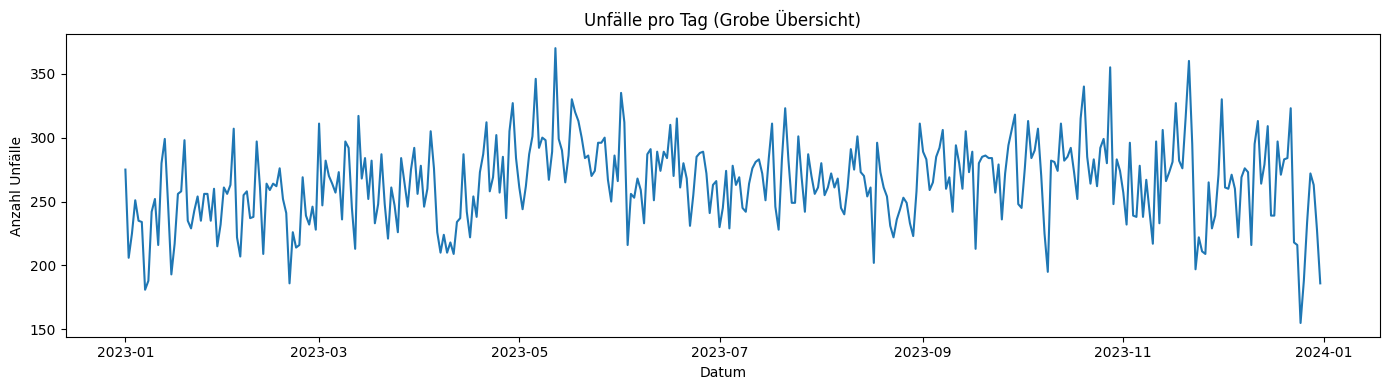

Abbildung gespeichert: crashes_per_day.png


In [50]:
# Datum extrahieren
df_nypd['date'] = df_nypd['crash_datetime'].dt.date

# Unfälle pro Tag
crashes_per_day = df_nypd.groupby('date').size()

# Plot
plt.figure(figsize=(14,4))
crashes_per_day.plot()
plt.title("Unfälle pro Tag (Grobe Übersicht)")
plt.ylabel("Anzahl Unfälle")
plt.xlabel("Datum")
plt.tight_layout()

# Speichern
save_dir = os.path.join(FIGURES_DIR, "02A_nypd_data_preparation")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "crashes_per_day.png")
plt.savefig(save_path, dpi=300)

plt.show()
print("Abbildung gespeichert:", os.path.basename(save_path))


### 2.8 Räumliche Übersicht

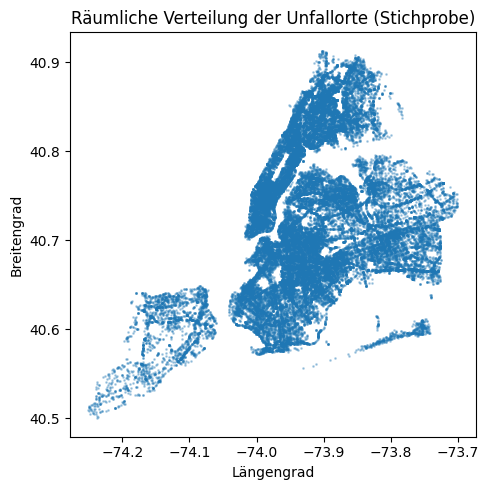

Abbildung gespeichert: crash_locations_sample.png


In [51]:
# Nur gültige NYC-Koordinaten auswählen
valid_nypd = df_nypd[
    df_nypd['LATITUDE'].between(40, 41) &
    df_nypd['LONGITUDE'].between(-75, -73)
].copy()

# Erste räumliche Übersicht: zufälliges Sample der Unfallorte visualisieren
sample_nypd = valid_nypd.sample(50_000, random_state=42)

plt.figure(figsize=(5,5))
plt.scatter(sample_nypd['LONGITUDE'], sample_nypd['LATITUDE'], s=1, alpha=0.3)
plt.title("Räumliche Verteilung der Unfallorte (Stichprobe)")
plt.xlabel("Längengrad")
plt.ylabel("Breitengrad")
plt.tight_layout()

# Speichern
save_dir = os.path.join(FIGURES_DIR, "02A_nypd_data_preparation")
os.makedirs(save_dir, exist_ok=True)
save_path = os.path.join(save_dir, "crash_locations_sample.png")
plt.savefig(save_path, dpi=300)

plt.show()
print("Abbildung gespeichert:", os.path.basename(save_path))

## 3. Bereinigung und Aufbereitung des Datensatzes

In diesem Abschnitt wird der finale, konsistent bereinigte NYPD-Datensatz erzeugt.
Die explorativen Analysen in Kapitel 2 dienten lediglich der Orientierung;
hier werden die zentralen Bereinigungsschritte noch einmal in klar definierter Reihenfolge und ohne Zwischenausgaben ausgeführt, um eine vollständig reproduzierbare Single Source of Truth zu erhalten.

Die Ausgangsbasis umfasst 96606 polizeilich erfasste Unfälle in New York City im Jahr 2023.
Im Rahmen der Aufbereitung werden folgende Schritte ausgeführt:

**1. Zeitliche Konsistenz herstellen**
Zunächst wird aus `CRASH DATE` und `CRASH TIME` ein Zeitstempel `crash_datetime` erzeugt.
Damit steht für jede Unfallzeile ein vollständiges und eindeutig interpretierbares Datum-Zeit-Feld zur Verfügung, das für alle weiteren Analysen genutzt werden kann.

**2. Fahrrad-/E-Bike-Beteiligung markieren**
Anschließend wird das Flag `cyclist_involved` berechnet, das Unfälle mit Beteiligung von Fahrrad- oder E-Bike-Fahrenden kennzeichnet. Dies geschieht sowohl über die in den Daten erfassten Verletzungs- bzw. Todesmeldungen von Radfahrenden als auch über die erkannten Fahrzeugtypen in den fünf Vehicle-Code-Spalten. 

**3. Räumliche Konsistenz sicherstellen**
Ein wesentlicher Schritt betrifft die Qualität der Geodaten. Für räumliche Auswertungen sind vollständige und valide Koordinaten zwingend erforderlich. Daher werden zunächst alle Zeilen entfernt, in denen Koordinaten fehlen oder als 0.0/0.0 codiert sind. Insgesamt betrifft dies **7593 Unfälle**. Anschließend werden Koordinaten außerhalb des geografisch plausiblen NYC-Bereichs entfernt; diese Prüfung ergibt in diesem Fall keine zusätzlichen Ausschlüsse. Die `LOCATION`-Spalte liefert für keinen der Fälle verwertbare Ersatzkoordinaten, sodass alle Zeilen ohne nutzbare Geoposition konsequent ausgeschlossen werden müssen.

Nach Durchführung aller Schritte verbleiben `89013` räumlich und zeitlich konsistente Unfälle. Der Datensatz weist eine vollständige zeitliche Abdeckung für das Jahr 2023 auf, enthält ein robust definiertes Fahrrad-/E-Bike-Flag und ist frei von strukturell unbrauchbaren Einträgen. Damit steht eine bereinigte, homogene und reproduzierbare Grundlage für alle weiteren Analysen zur Verfügung — insbesondere für räumliche Muster, Expositionsschätzungen und spätere Risikomodellierung.

In [52]:
# Kopie des Rohdatensatzes
df_nypd_clean = df_nypd_raw.copy()

# Zeitstempel zusammenführen
df_nypd_clean['crash_datetime'] = pd.to_datetime(
    df_nypd_clean['CRASH DATE'].astype(str).str.strip() + " " +
    df_nypd_clean['CRASH TIME'].astype(str).str.strip(),
    errors='coerce'
)

# Fahrrad-/E-Bike-Involvement Flag setzen
df_nypd_clean['cyclist_involved'] = (
    (df_nypd_clean['NUMBER OF CYCLIST INJURED'] > 0) |
    (df_nypd_clean['NUMBER OF CYCLIST KILLED'] > 0) |
    df_nypd_clean.apply(row_has_bike_vehicle, axis=1)
)

# Anzahl Zeilen vor der Bereinigung
initial_rows = len(df_nypd_clean)

# Entfernen von NaN-Koordinaten und 0/0-Codes
mask_missing_geo = (
    df_nypd_clean['LATITUDE'].isna() |
    df_nypd_clean['LONGITUDE'].isna() |
    ((df_nypd_clean['LATITUDE'] == 0) & (df_nypd_clean['LONGITUDE'] == 0))
)
# Anzahl der Zeilen mit fehlenden oder ungültigen Koordinaten bestimmen
removed_missing = int(mask_missing_geo.sum())

df_nypd_clean = df_nypd_clean[~mask_missing_geo]


# Entfernen räumlich unplausibler Koordinaten
mask_valid_bounds = (
    df_nypd_clean['LATITUDE'].between(40, 41) &
    df_nypd_clean['LONGITUDE'].between(-75, -73)
)
# Anzahl der Zeilen bestimmen, deren Koordinaten außerhalb des NYC-Gültigkeitsbereichs liegen
removed_outside = int((~mask_valid_bounds).sum())

df_nypd_clean = df_nypd_clean[mask_valid_bounds]

# Zusammenfasssung
final_rows = len(df_nypd_clean)
retention_rate = final_rows / initial_rows

print(f"Anzahl verbleibender Zeilen: {final_rows}")
print(f"Anteil der behaltenen Zeilen: {retention_rate:.2%}")
print(f"Entfernte Zeilen (fehlende oder ungültige Koordinaten): {removed_missing}")
print(f"Entfernte Zeilen (außerhalb NYC-Grenzen): {removed_outside}")

# Speichern
path_clean = os.path.join(DATA_PROCESSED, 'nypd_clean.parquet')
df_nypd_clean.to_parquet(path_clean, index=False)
print('Bereinigter Datensatz gespeichert:', os.path.basename(path_clean))

Anzahl verbleibender Zeilen: 89013
Anteil der behaltenen Zeilen: 92.14%
Entfernte Zeilen (fehlende oder ungültige Koordinaten): 7593
Entfernte Zeilen (außerhalb NYC-Grenzen): 0
Bereinigter Datensatz gespeichert: nypd_clean.parquet
